# Dataset

All experiments in this project will use the **Pascal VOC Detection** dataset, which is one of the most widely used benchmarks for object detection. This dataset contains 178k images collected from a wide variety of scenes. An image can contain multiple objects of different classes, for a total of 20 object categories. Each object is annotated with a class label and a bounding box that tightly enclose its pixels. The bounding box is an axis-aligned rectangle represented by the coordinates of its top-left and bottom-right corners: (xmin, ymin, xmax, ymax).

## VOC Detection

The Pascal VOC dataset can be directly accessed in PyTorch via the [`VOCDetection`](https://docs.pytorch.org/vision/master/generated/torchvision.datasets.VOCDetection.html) class from the TorchVision library.

In [1]:
from torchvision.datasets import VOCDetection

# On first run, set download=True to download the dataset
dataset = VOCDetection('.data/', download=False)

Each sample consists of an image and its corresponding annotations in a dictionary format. The annotations include various information, such as the bounding boxes and class labels for each object in the image.

In [2]:
image, target = dataset[0]  # Sample at index 0

target['annotation']['object']  # Object list

[{'name': 'horse',
  'pose': 'Left',
  'truncated': '0',
  'occluded': '1',
  'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
  'difficult': '0'},
 {'name': 'person',
  'pose': 'Unspecified',
  'truncated': '1',
  'occluded': '0',
  'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
  'difficult': '0'}]

PyTorch provides utility functions to manipulate and visualize the bounding boxes of an image. These functions require the coordinates to be converted into the [`BoundingBoxes`](https://docs.pytorch.org/vision/master/generated/torchvision.tv_tensors.BoundingBoxes.html#torchvision.tv_tensors.BoundingBoxes) type.

In [3]:
from torchvision.tv_tensors import BoundingBoxes

boxes = []
for obj in target['annotation']['object']:
    bbox = obj['bndbox']
    coords = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
    boxes.append(coords)

height = int(target['annotation']['size']['height'])
width  = int(target['annotation']['size']['width'])

boxes = BoundingBoxes(boxes, format='XYXY', canvas_size=(height, width))
boxes

BoundingBoxes([[ 53,  87, 471, 420],
               [158,  44, 289, 167]], format=BoundingBoxFormat.XYXY, canvas_size=(442, 500))

Then, the visualization is done using the [`draw_bounding_boxes`](https://docs.pytorch.org/vision/master/generated/torchvision.utils.draw_bounding_boxes.html#torchvision.utils.draw_bounding_boxes) function.

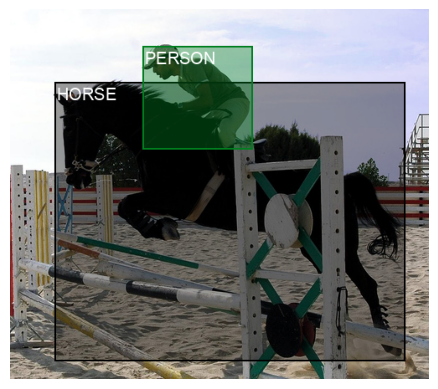

In [4]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2.functional import to_image
import matplotlib.pyplot as plt

tensor_image = to_image(image) # convert PIL image to tensor

class_labels = [obj['name'].upper() for obj in target['annotation']['object']]

image_with_boxes = draw_bounding_boxes(tensor_image, boxes, class_labels, fill=True, label_colors='white', width=2, font='Arial.ttf', font_size=20)

plt.imshow(image_with_boxes.permute(1, 2, 0)) # convert channel-first to channel-last
plt.axis('off')
plt.show()

## Custom Dataset

When working on single-object localization, you cannot use all images from the Pascal VOC dataset, as many of them contain multiple objects. Instead, you need to filter the dataset to include only the images that contain **at most one instance of a chosen category**. To achieve this, you create a custom dataset class like the one provided below. The latter wraps a `VOCDetection` dataset and keeps track of a list of indices. The `__getitem__` method relies on these indices to return only a subset of the original dataset.

Notice that the list of indices (`self.indices`) is initially empty. Your task is to populate it with the indices of images that you want to include in the dataset, i.e., those that contain at most one object of the chosen category. Once you have done that, the dataset will behave like a filtered version of `VOCDetection`.

In [ ]:
from torch.utils.data import Dataset
from torchvision.datasets import VOCDetection, wrap_dataset_for_transforms_v2


class FilteredVOCDetection(Dataset):
    """
    A wrapper around VOCDetection that only includes images with at most one instance of a specified category.
    """

    def __init__(self, voc: VOCDetection, category: str, transforms=None):
        self.voc = wrap_dataset_for_transforms_v2(voc)
        self.transforms = transforms
        self.indices: list[int] = []  # TODO: You must populate this list

    def __len__(self) -> int:
        return len(self.indices)
    
    def __getitem__(self, idx) -> tuple:
        image, target = self.voc[self.indices[idx]]
        
        if self.transforms:
            image, target = self.transforms(image, target)
        
        return image, target

:::{note}
The `wrap_dataset_for_transforms_v2` function is a utility that reformats the annotations of a TorchVision dataset. It produces the following changes when applied to the `VOCDetection` dataset.

 - The bounding boxes are extracted into a tensor of shape `(num_objects, 4)` and converted to the `BoundingBoxes` subtype.
 - The labels are extracted into a tensor of shape `(num_objects,)`.

These tensors are stored in a dictionary returned as the second element of each sample.

```python
image, target = wrapped_voc[idx]
```

The keys of this dictionary are `'boxes'` and `'labels'`.

### Filtering images by category

As mentioned before, in the single-object localization setting, you want to filter the Pascal VOC dataset to include only images that contain at most one instance of a chosen category. For example, if your category is "cat", you want to include images with no cats or exactly one cat, but you exclude images with multiple cats. To do this, you iterate through the entire `VOCDetection` dataset and check the annotations of each image. If an image contains zero or one object of the chosen category, you add its index to a list. 

To make the process more efficient, instead of loading every image and its annotations through the `__getitem__` method of the dataset, you can directly read the Pascal VOC XML annotation files. Each image has a corresponding XML file that lists all objects and their labels. The function below shows how to parse an XML file for a given sample index in the `VOCDetection` dataset.

In [ ]:
from torchvision.datasets import VOCDetection
from xml.etree.ElementTree import parse as ET_parse


def read_annotation(voc: VOCDetection, idx: int) -> dict:
    """
    Reads the annotation file for a given sample index in the VOCDetection dataset.
    """
    file = voc.annotations[idx]
    root = ET_parse(file).getroot()
    return VOCDetection.parse_voc_xml(root)

## Final notes

The `FilteredVOCDetection` dataset provides a controlled environment for single-object localization, allowing you to focus on designing and evaluating your first localization model. In later stages, when working on multi-object localization, you will use the full Pascal VOC dataset instead.